In [ ]:
#!mamba env create -f '../../environment.yml'
!mamba env update -f '../../environment.yml' --prune

# Testing examples from remote_sensing 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import shapely
import dask
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime
import pandas as pd
import numpy as np
import contextily as ctx
import rasterio as rio

In [3]:
bbox_gdf = gpd.read_file(
    "https://github.com/egagli/easysnowdata/raw/main/docs/examples/mt_rainier.geojson"
)

## Forest cover fraction

In [4]:
%%time
forest_cover_fraction = easysnowdata.remote_sensing.get_forest_cover_fraction(bbox_gdf)
forest_cover_fraction

CPU times: user 117 ms, sys: 17.9 ms, total: 135 ms
Wall time: 9.05 s


<xarray.DataArray (y: 272, x: 405)> Size: 441kB
dask.array<getitem, shape=(272, 405), dtype=float32, chunksize=(272, 405), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB -121.9 -121.9 -121.9 ... -121.5 -121.5 -121.5
  * y            (y) float64 2kB 47.0 47.0 47.0 46.99 ... 46.73 46.73 46.73
    spatial_ref  int64 8B 0
Attributes: (12/31)
    archive_facility:       VITO NV
    AREA_OR_POINT:          Area
    copyright:              Copernicus Service information 2020
    creator:                Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:  WGS84 (EPSG:4326)
    doi:                    10.5281/zenodo.3939050
    ...                     ...
    time_reference_year:    2019
    title:                  Dynamic Land Cover Map 100m 2019-nrt
    band_crs:               WGS84 (EPSG:4326)
    short_name:             Tree-CoverFraction-layer
    unit:                   %
    valid_range:            0, 100

Text(0.5, 1.0, 'Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

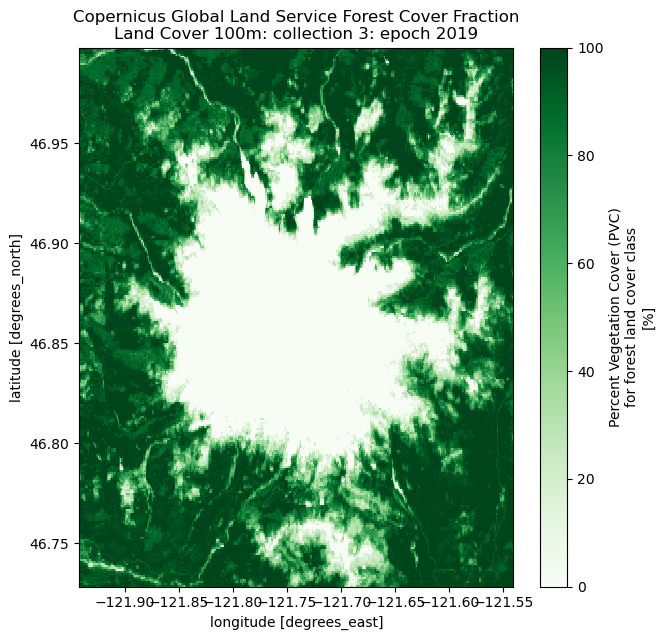

In [5]:
f, ax = plt.subplots(figsize=(7, 7))

forest_cover_fraction.plot(ax=ax, cmap="Greens")

ax.set_title(
    "Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019"
)

## Seasonal snow classification (Sturm & Liston 2021)

In [6]:
%%time
snow_classification = easysnowdata.remote_sensing.get_seasonal_snow_classification(bbox_gdf)
snow_classification

CPU times: user 126 ms, sys: 25.7 ms, total: 151 ms
Wall time: 7.37 s


<xarray.DataArray (y: 98, x: 146)> Size: 57kB
dask.array<getitem, shape=(98, 146), dtype=float32, chunksize=(53, 146), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 1kB -121.9 -121.9 -121.9 ... -121.5 -121.5 -121.5
  * y            (y) float64 784B 47.0 47.0 46.99 46.99 ... 46.73 46.73 46.73
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         Band 1
    long_name:      Band 1
    class_info:     {1: {'name': 'Tundra', 'color': '#a100c8'}, 2: {'name': '...

Text(0.5, 1.0, 'Seasonal Snow Classification\nfrom Sturm & Liston 2021')

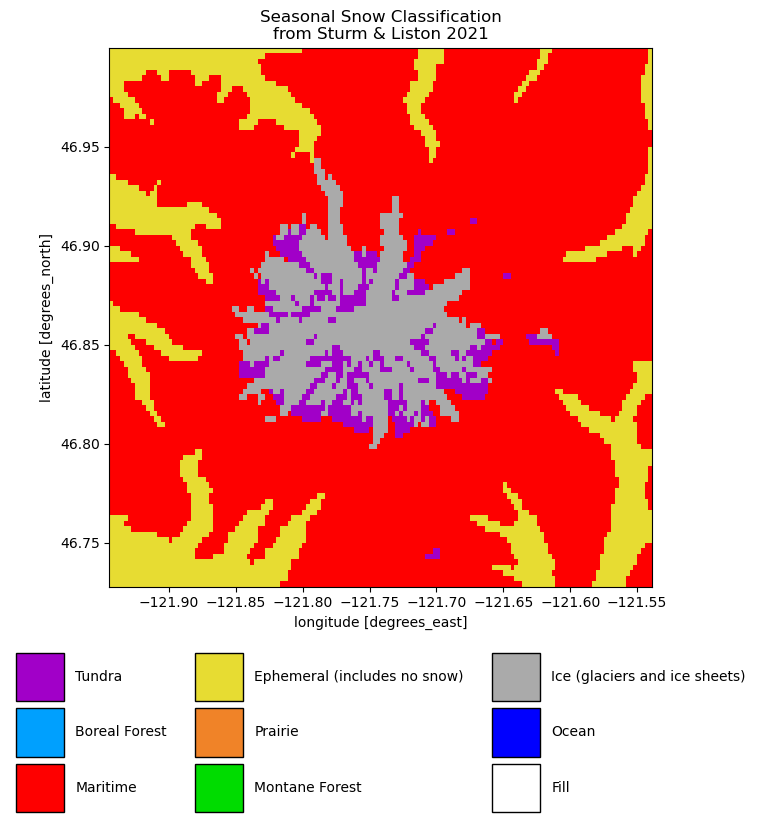

In [7]:
f, ax = plt.subplots(figsize=(7, 7))

# Get the class names and class colors from the attributes
class_names = [
    class_info["name"]
    for class_info in snow_classification.attrs["class_info"].values()
]
class_colors = [
    class_info["color"]
    for class_info in snow_classification.attrs["class_info"].values()
]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(snow_classification.attrs["class_info"].keys()))
bounds = [
    (class_values[i] + class_values[i + 1]) / 2 for i in range(len(class_values) - 1)
]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
snow_classification.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(
        plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor="black")
    )
ax.legend(
    legend_handles,
    class_names,
    bbox_to_anchor=(0.5, -0.1),
    loc="upper center",
    ncol=len(class_names) / 3,
    frameon=False,
    handlelength=3.5,
    handleheight=5,
)

ax.set_title("Seasonal Snow Classification\nfrom Sturm & Liston 2021")

## ESA WorldCover

In [8]:
%%time
esa_worldcover = easysnowdata.remote_sensing.get_esa_worldcover(bbox_gdf)
esa_worldcover

CPU times: user 83.2 ms, sys: 8.43 ms, total: 91.6 ms
Wall time: 2.43 s


<xarray.DataArray 'map' (latitude: 3227, longitude: 4811)> Size: 16MB
dask.array<getitem, shape=(3227, 4811), dtype=uint8, chunksize=(3227, 4811), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 26kB 47.0 47.0 47.0 ... 46.73 46.73 46.73
  * longitude    (longitude) float64 38kB -121.9 -121.9 -121.9 ... -121.5 -121.5
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-01-01
Attributes:
    nodata:      0
    class_info:  {10: {'name': 'Tree cover', 'color': '#006400'}, 20: {'name'...

Text(0.5, 1.0, 'ESA WorldCover\n2021 v200')

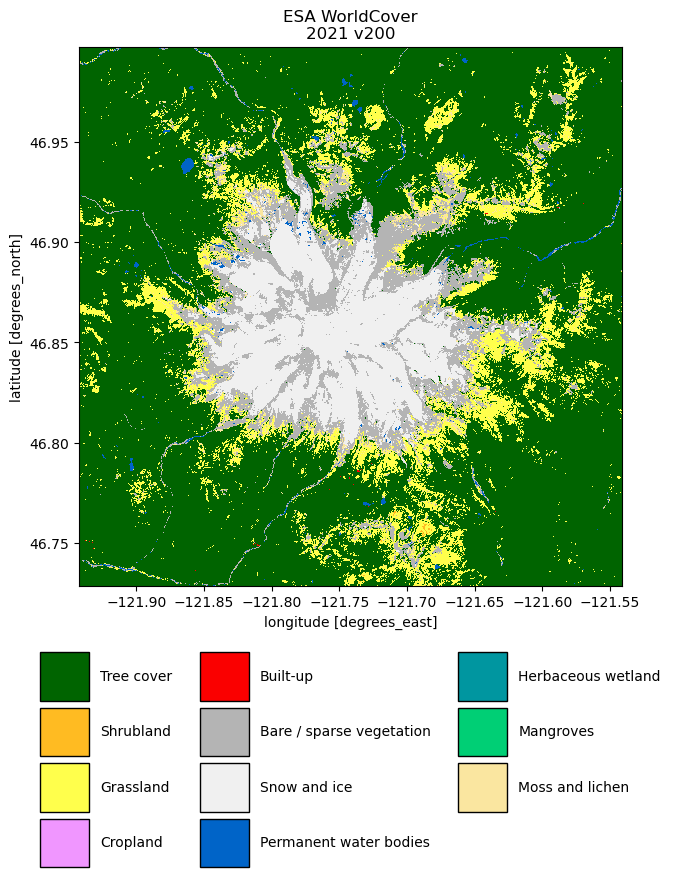

In [9]:
f, ax = plt.subplots(figsize=(7, 7))

# Get the class names and class colors from the attributes
class_names = [
    class_info["name"] for class_info in esa_worldcover.attrs["class_info"].values()
]
class_colors = [
    class_info["color"] for class_info in esa_worldcover.attrs["class_info"].values()
]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(esa_worldcover.attrs["class_info"].keys()))
bounds = [
    (class_values[i] + class_values[i + 1]) / 2 for i in range(len(class_values) - 1)
]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
esa_worldcover.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(
        plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor="black")
    )
ax.legend(
    legend_handles,
    class_names,
    bbox_to_anchor=(0.5, -0.1),
    loc="upper center",
    ncol=len(class_names) / 3,
    frameon=False,
    handlelength=3.5,
    handleheight=5,
)

ax.set_title("ESA WorldCover\n2021 v200")

## Sentinel-2

In [10]:
s2 = easysnowdata.remote_sensing.Sentinel2(
    bbox_input=bbox_gdf,
    start_date="2022-07-01",
    end_date="2022-07-31",
    catalog_choice="planetarycomputer",
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data acquired after January 25th, 2022 harmonized to old baseline. To turn this behavior off, set harmonize_to_old=False.
Data scaled to reflectance. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute.


In [11]:
s2.data

<xarray.Dataset> Size: 8GB
Dimensions:      (y: 3038, x: 3105, time: 13)
Coordinates:
  * y            (y) float64 24kB 5.206e+06 5.206e+06 ... 5.176e+06 5.176e+06
  * x            (x) float64 25kB 5.804e+05 5.804e+05 ... 6.114e+05 6.115e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 104B 2022-07-01T18:59:19.024000 ... 20...
Data variables: (12/16)
    coastal      (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    blue         (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    green        (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    red          (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    rededge      (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    rededge2     (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    swir22       (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    aot          (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    scl          (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    wvp          (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
    visual       (time, y, x) float32 491MB dask.array<chunksize=(1, 3038, 3105), meta=np.ndarray>
Attributes:
    band_info:       {'B01': {'name': 'coastal', 'description': 'Coastal aero...
    scl_class_info:  {0: {'name': 'No Data (Missing data)', 'color': '#000000...

In [12]:
s2.get_rgb()
s2.rgb

RGB data retrieved. Access with the .rgb attribute.


<xarray.DataArray (band: 3, time: 13, y: 3038, x: 3105)> Size: 1GB
dask.array<stack, shape=(3, 13, 3038, 3105), dtype=float32, chunksize=(1, 1, 3038, 3105), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 24kB 5.206e+06 5.206e+06 ... 5.176e+06 5.176e+06
  * x            (x) float64 25kB 5.804e+05 5.804e+05 ... 6.114e+05 6.115e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 104B 2022-07-01T18:59:19.024000 ... 20...
  * band         (band) object 24B 'red' 'green' 'blue'
Attributes:
    band_info:       {'B01': {'name': 'coastal', 'description': 'Coastal aero...
    scl_class_info:  {0: {'name': 'No Data (Missing data)', 'color': '#000000...

Text(0.5, 1.02, 'Sentinel-2 RGB')

/home/eric/miniconda3/envs/easysnowdata/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


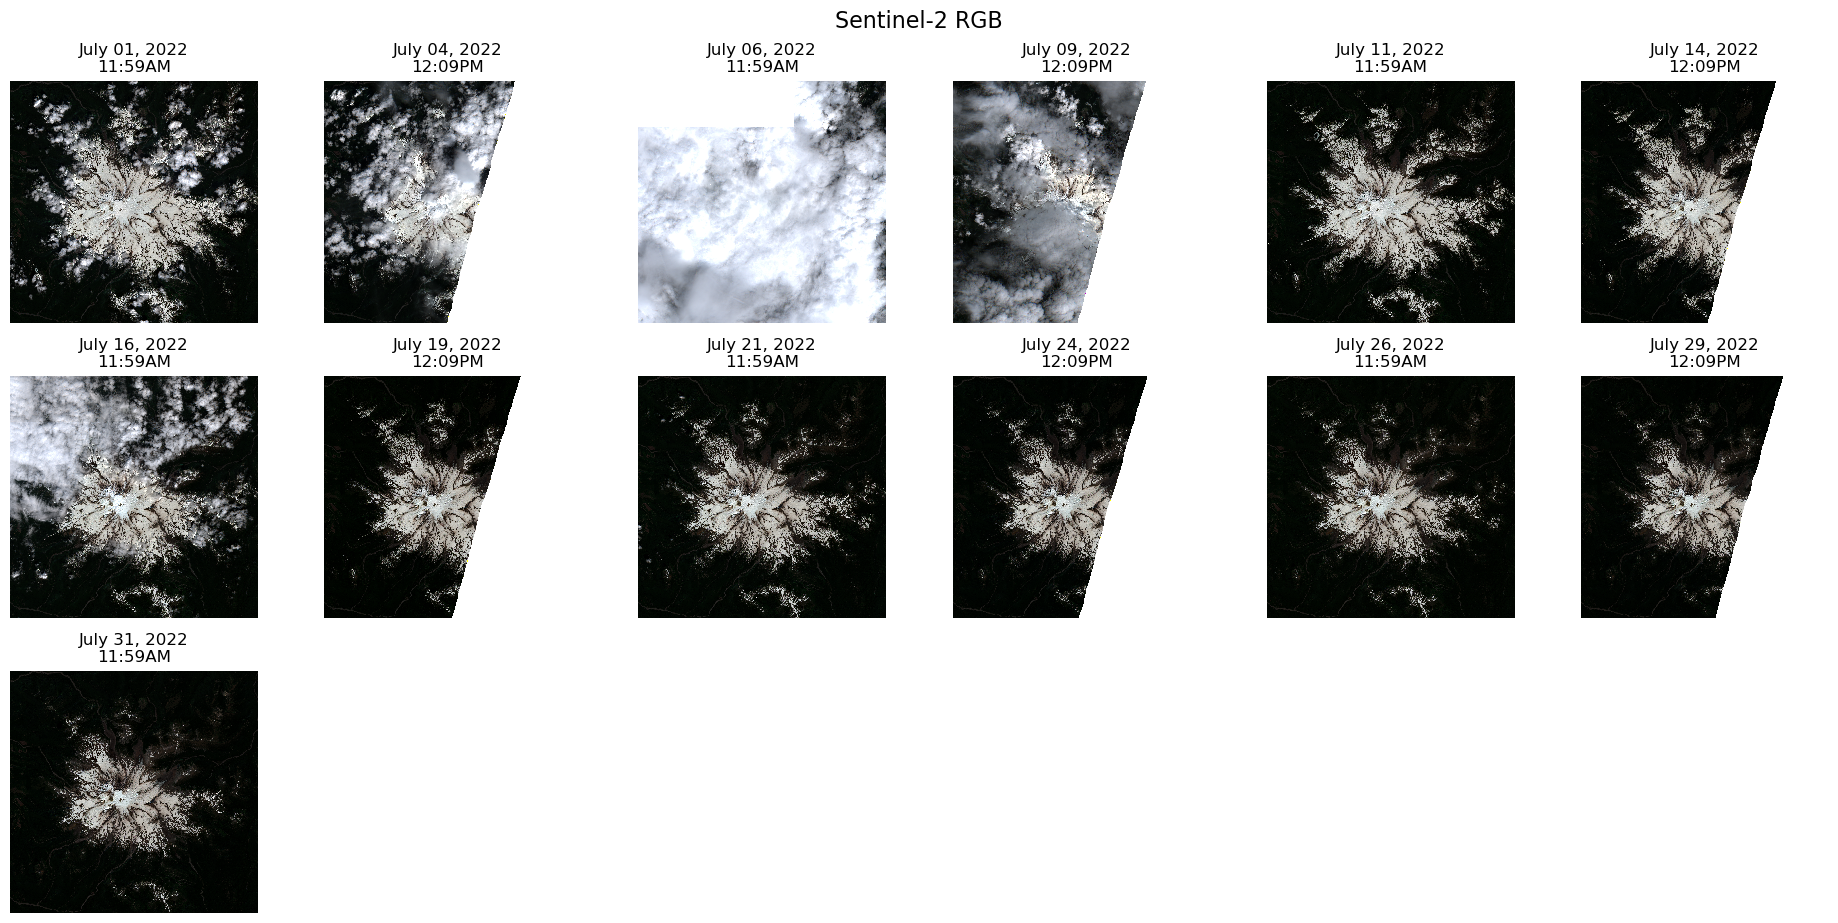

In [13]:
f = s2.rgb.plot.imshow(col='time',col_wrap=6, robust=True)

for ax, time, in zip(f.axs.flat, s2.rgb.time.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
    ax.axis('off')
    ax.set_aspect('equal')
    
f.fig.tight_layout()

f.fig.suptitle('Sentinel-2 RGB', fontsize=16, y=1.02)

In [14]:
s2.data.scl

<xarray.DataArray 'scl' (time: 13, y: 3038, x: 3105)> Size: 491MB
dask.array<where, shape=(13, 3038, 3105), dtype=float32, chunksize=(1, 3038, 3105), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 24kB 5.206e+06 5.206e+06 ... 5.176e+06 5.176e+06
  * x            (x) float64 25kB 5.804e+05 5.804e+05 ... 6.114e+05 6.115e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 104B 2022-07-01T18:59:19.024000 ... 20...
Attributes:
    nodata:          0
    scl_class_info:  {0: {'name': 'No Data (Missing data)', 'color': '#000000...

In [15]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in s2.data.scl.attrs['scl_class_info'].values()]
class_colors = [class_info['color'] for class_info in s2.data.scl.attrs['scl_class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(s2.data.scl.attrs['scl_class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
s2.data.scl.isel(time=10).plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/4,frameon=False,handlelength=3.5, handleheight=5)

local_time = pd.to_datetime(s2.data.scl.isel(time=10).time.values).tz_localize('UTC').tz_convert('America/Los_Angeles')

ax.set_title(f'Sentinel-2 Scene Classification Layer (SCL)\n{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
ax.set_aspect('equal')

/home/eric/miniconda3/envs/easysnowdata/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TES.2022192T185919.v2.0/HLS.S30.T10TES.2022192T185919.v2.0.B02.tif:1
Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T10TES.2022186T184942.v2.0/HLS.L30.T10TES.2022186T184942.v2.0.B03.tif:1


Text(0.5, 1.02, 'Sentinel-2 SCL time series')

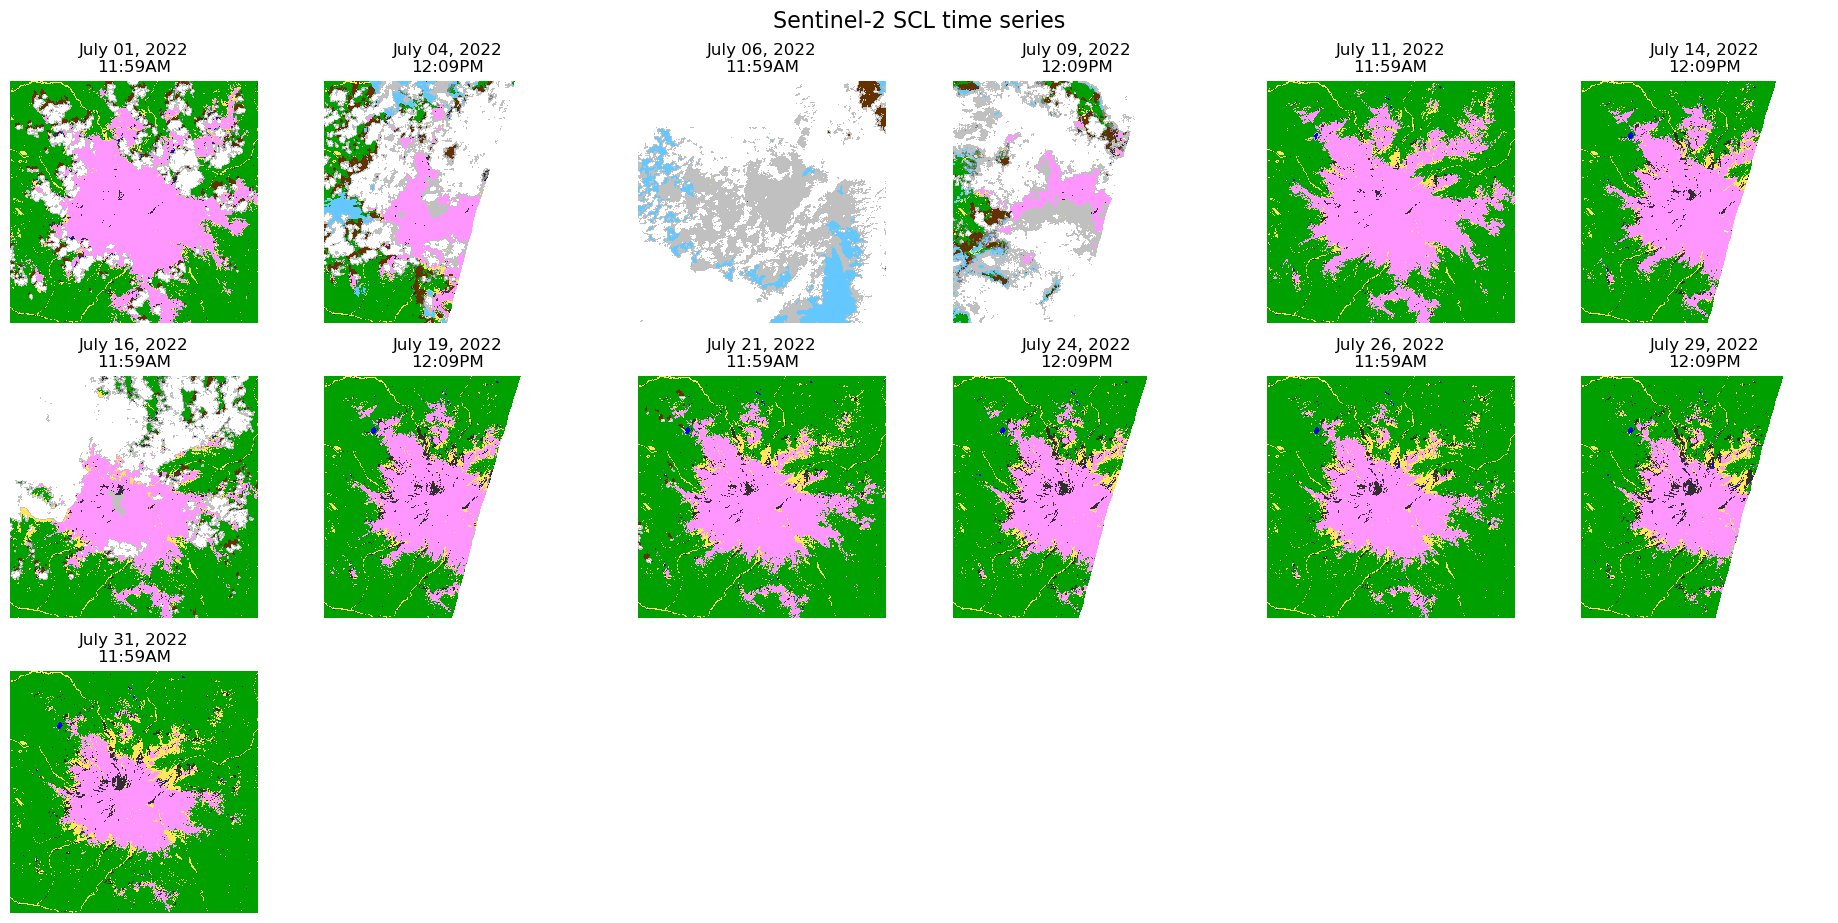

In [16]:
f = s2.data.scl.plot.imshow(col='time',col_wrap=6, cmap=cmap, add_colorbar=False, norm=norm)

for ax, time, in zip(f.axs.flat, s2.data.scl.time.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
    ax.axis('off')
    ax.set_aspect('equal')
    
f.fig.tight_layout()

f.fig.suptitle('Sentinel-2 SCL time series',fontsize=16,y=1.02)

### Let's say we want to calculate NDSI. That would be hard with all of these clouds and shadows! Let's mask the data we are not interested in. You can mask data by passing boolean values to .mask_data(). By default, no data, saturated pixels, topographic shadows, cloud shadows, cloud medium probability, cloud high probability, and thin cirrus are all removed.

In [17]:
s2.mask_data()

Removed pixels with the following scene classification values:
No Data (Missing data)
Saturated or defective pixel
Topographic casted shadows
Cloud shadows
Cloud medium probability
Cloud high probability
Thin cirrus


In [18]:
s2.get_ndsi()
s2.ndsi

NDSI data calculated. Access with the .ndsi attribute.


<xarray.DataArray (time: 13, y: 3038, x: 3105)> Size: 491MB
dask.array<truediv, shape=(13, 3038, 3105), dtype=float32, chunksize=(1, 3038, 3105), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 24kB 5.206e+06 5.206e+06 ... 5.176e+06 5.176e+06
  * x            (x) float64 25kB 5.804e+05 5.804e+05 ... 6.114e+05 6.115e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 104B 2022-07-01T18:59:19.024000 ... 20...

KeyboardInterrupt: 

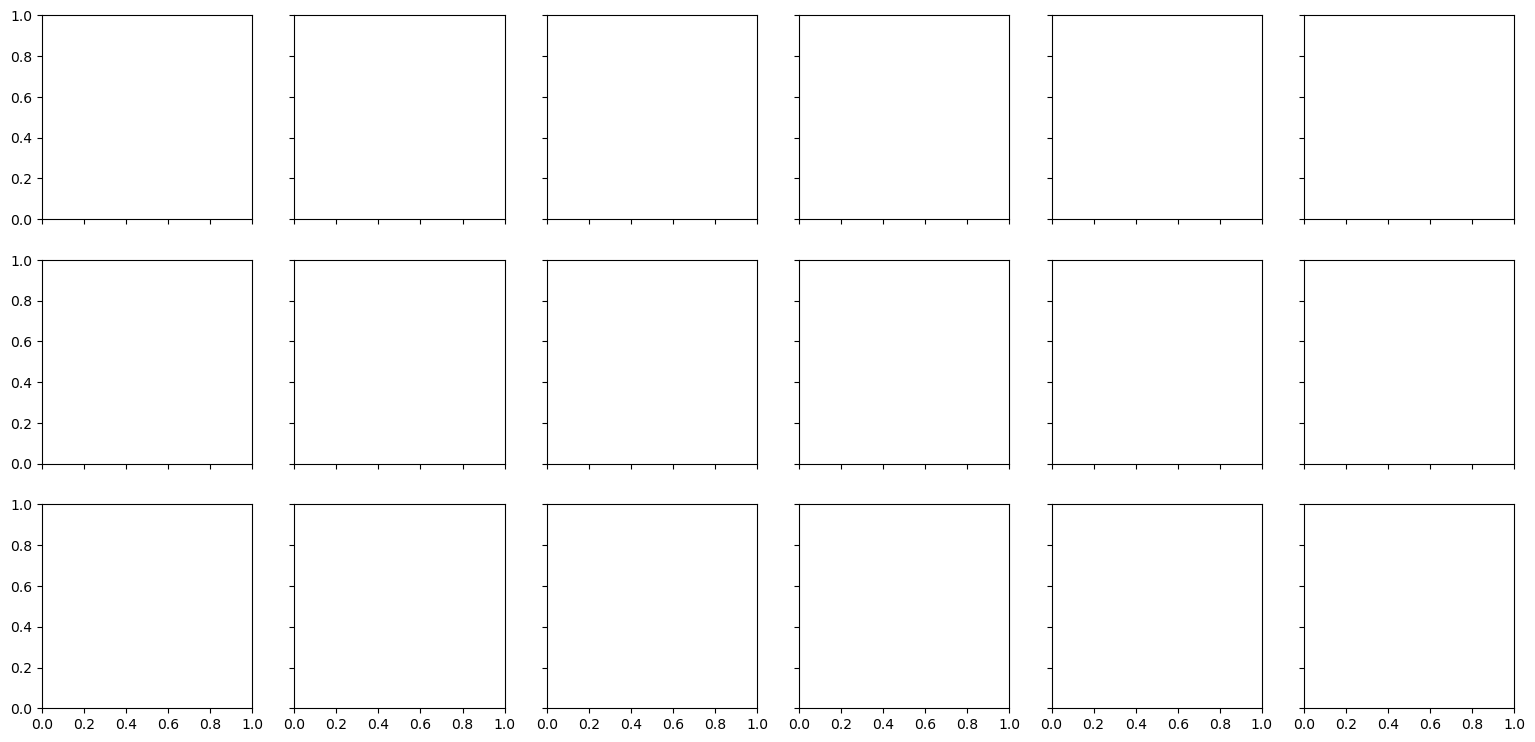

In [20]:
f = s2.ndsi.plot.imshow(col='time',col_wrap=6)

for ax, time, in zip(f.axs.flat, s2.ndsi.time.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.suptitle('Sentinel-2 NDSI time series',fontsize=16,y=1.02)

In [ ]:
s2.get_ndvi()
s2.ndvi

In [ ]:
f = s2.ndvi.plot.imshow(col='time',col_wrap=6)

for ax, time, in zip(f.axs.flat, s2.ndvi.time.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
    ax.axis('off')
    ax.set_aspect('equal')
    

f.fig.suptitle('Sentinel-2 NDVI time series',fontsize=16,y=1.02)

## Sentinel-1

In [ ]:
#!planetarycomputer configure

In [21]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=bbox_gdf, start_date="2022-07-01", end_date="2022-07-31", resolution=80
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Metadata retrieved. Access with the .metadata attribute.
Border noise removed from the data.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [22]:
s1.data

<xarray.Dataset> Size: 12MB
Dimensions:             (y: 380, x: 389, time: 10)
Coordinates:
  * y                   (y) float64 3kB 5.206e+06 5.206e+06 ... 5.176e+06
  * x                   (x) float64 3kB 5.804e+05 5.805e+05 ... 6.115e+05
    spatial_ref         int32 4B 32610
  * time                (time) datetime64[ns] 80B 2022-07-03T14:14:09.704314 ...
    sat:orbit_state     (time) object 80B 'descending' ... 'ascending'
    sat:relative_orbit  (time) int16 20B 115 137 13 64 115 137 13 64 115 137
Data variables:
    vh                  (time, y, x) float32 6MB dask.array<chunksize=(10, 380, 389), meta=np.ndarray>
    vv                  (time, y, x) float32 6MB dask.array<chunksize=(10, 380, 389), meta=np.ndarray>
Attributes:
    units:    dB

In [ ]:
f = s1.data['vv'].plot.imshow(col='time',col_wrap=6, vmin=-15, vmax=2, cmap='gray')

for ax, time, in zip(f.axs.flat, s1.data['vv'].time.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.suptitle('Sentinel-1 RTC backscatter time series',fontsize=16,y=1.02)

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))

s1.metadata.plot(
    "sat:relative_orbit",
    ax=ax,
    edgecolor="black",
    categorical=True,
    legend=True,
    alpha=0.2,
)
bbox_gdf.plot(ax=ax, edgecolor="black", facecolor="none")
ctx.add_basemap(ax, crs=s1.metadata.crs, source=ctx.providers.Esri.WorldImagery)

## Harmonized Landsat Sentinel-2 v2.0

In [ ]:
# !CPL_VSIL_CURL_USE_HEAD=FALSE
# !GDAL_DISABLE_READDIR_ON_OPEN=YES
# !GDAL_HTTP_COOKIEJAR=/tmp/cookies.txt
# !GDAL_HTTP_COOKIEFILE=/tmp/cookies.txt

# from osgeo import gdal
# gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
# gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
# gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR') #gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES') EMPTY_DIR
# gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
# gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
# gdal.SetConfigOption('GDAL_HTTP_NETRC','True')

In [23]:
hls = easysnowdata.remote_sensing.HLS(
    bbox_input=bbox_gdf, start_date="2022-07-01", end_date="2022-07-31"
)

Data searched. Access the returned seach with the .search_landsat or .search_sentinel attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 10N.
Nodata values removed from the data. In doing so, all bands converted to float32. To turn this behavior off, set remove_nodata=False.
Data scaled to reflectance. Access with the .data attribute. To turn this behavior off, set scale_data=False.
Metadata retrieved. Access with the .metadata attribute. To turn this behavior off, set add_metadata=False.
Platform, geometry, cloud cover, browse URLs added to data as coordinates. Access with the .data attribute. To turn this behavior off, set add_platform=False.


In [24]:
hls.data

<xarray.Dataset> Size: 2GB
Dimensions:                    (y: 1013, x: 1035, time: 21)
Coordinates:
  * y                          (y) float64 8kB 5.206e+06 5.206e+06 ... 5.176e+06
  * x                          (x) float64 8kB 5.804e+05 5.805e+05 ... 6.114e+05
    spatial_ref                int32 4B 32610
  * time                       (time) datetime64[ns] 168B 2022-07-01T19:11:28...
    platform                   (time) <U11 924B 'Sentinel-2B' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 168B 25 67 81 85 94 88 ... 0 7 1 0 3
    AssociatedBrowseImageUrls  (time) object 168B ['https://data.lpdaac.earth...
    geometry                   (time) object 168B MULTIPOLYGON (((-120.248915...
Data variables: (12/20)
    coastal aerosol            (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    blue                       (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    green                      (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red                        (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    nir narrow                 (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    swir 1                     (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ...                         ...
    VAA                        (time, y, x) float32 88MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    red-edge 1                 (time, y, x) float32 88MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 2                 (time, y, x) float32 88MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    red-edge 3                 (time, y, x) float32 88MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    nir broad                  (time, y, x) float32 88MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>
    water vapor                (time, y, x) float32 88MB dask.array<chunksize=(2, 512, 512), meta=np.ndarray>

In [25]:
hls.get_rgb()
hls.rgb

RGB data retrieved. Access with the .rgb attribute.


<xarray.DataArray (band: 3, time: 21, y: 1013, x: 1035)> Size: 264MB
dask.array<stack, shape=(3, 21, 1013, 1035), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y                          (y) float64 8kB 5.206e+06 5.206e+06 ... 5.176e+06
  * x                          (x) float64 8kB 5.804e+05 5.805e+05 ... 6.114e+05
    spatial_ref                int32 4B 32610
  * time                       (time) datetime64[ns] 168B 2022-07-01T19:11:28...
    platform                   (time) <U11 924B 'Sentinel-2B' ... 'Sentinel-2B'
    eo:cloud_cover_avg         (time) int64 168B 25 67 81 85 94 88 ... 0 7 1 0 3
    AssociatedBrowseImageUrls  (time) object 168B ['https://data.lpdaac.earth...
    geometry                   (time) object 168B MULTIPOLYGON (((-120.248915...
  * band                       (band) object 24B 'red' 'green' 'blue'

Ignoring read failure while reading: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TFT.2022192T185919.v2.0/HLS.S30.T10TFT.2022192T185919.v2.0.B04.tif:1


Text(0.5, 1.04, 'Harmonized Landsat Sentinel-2 (HLS) time series')

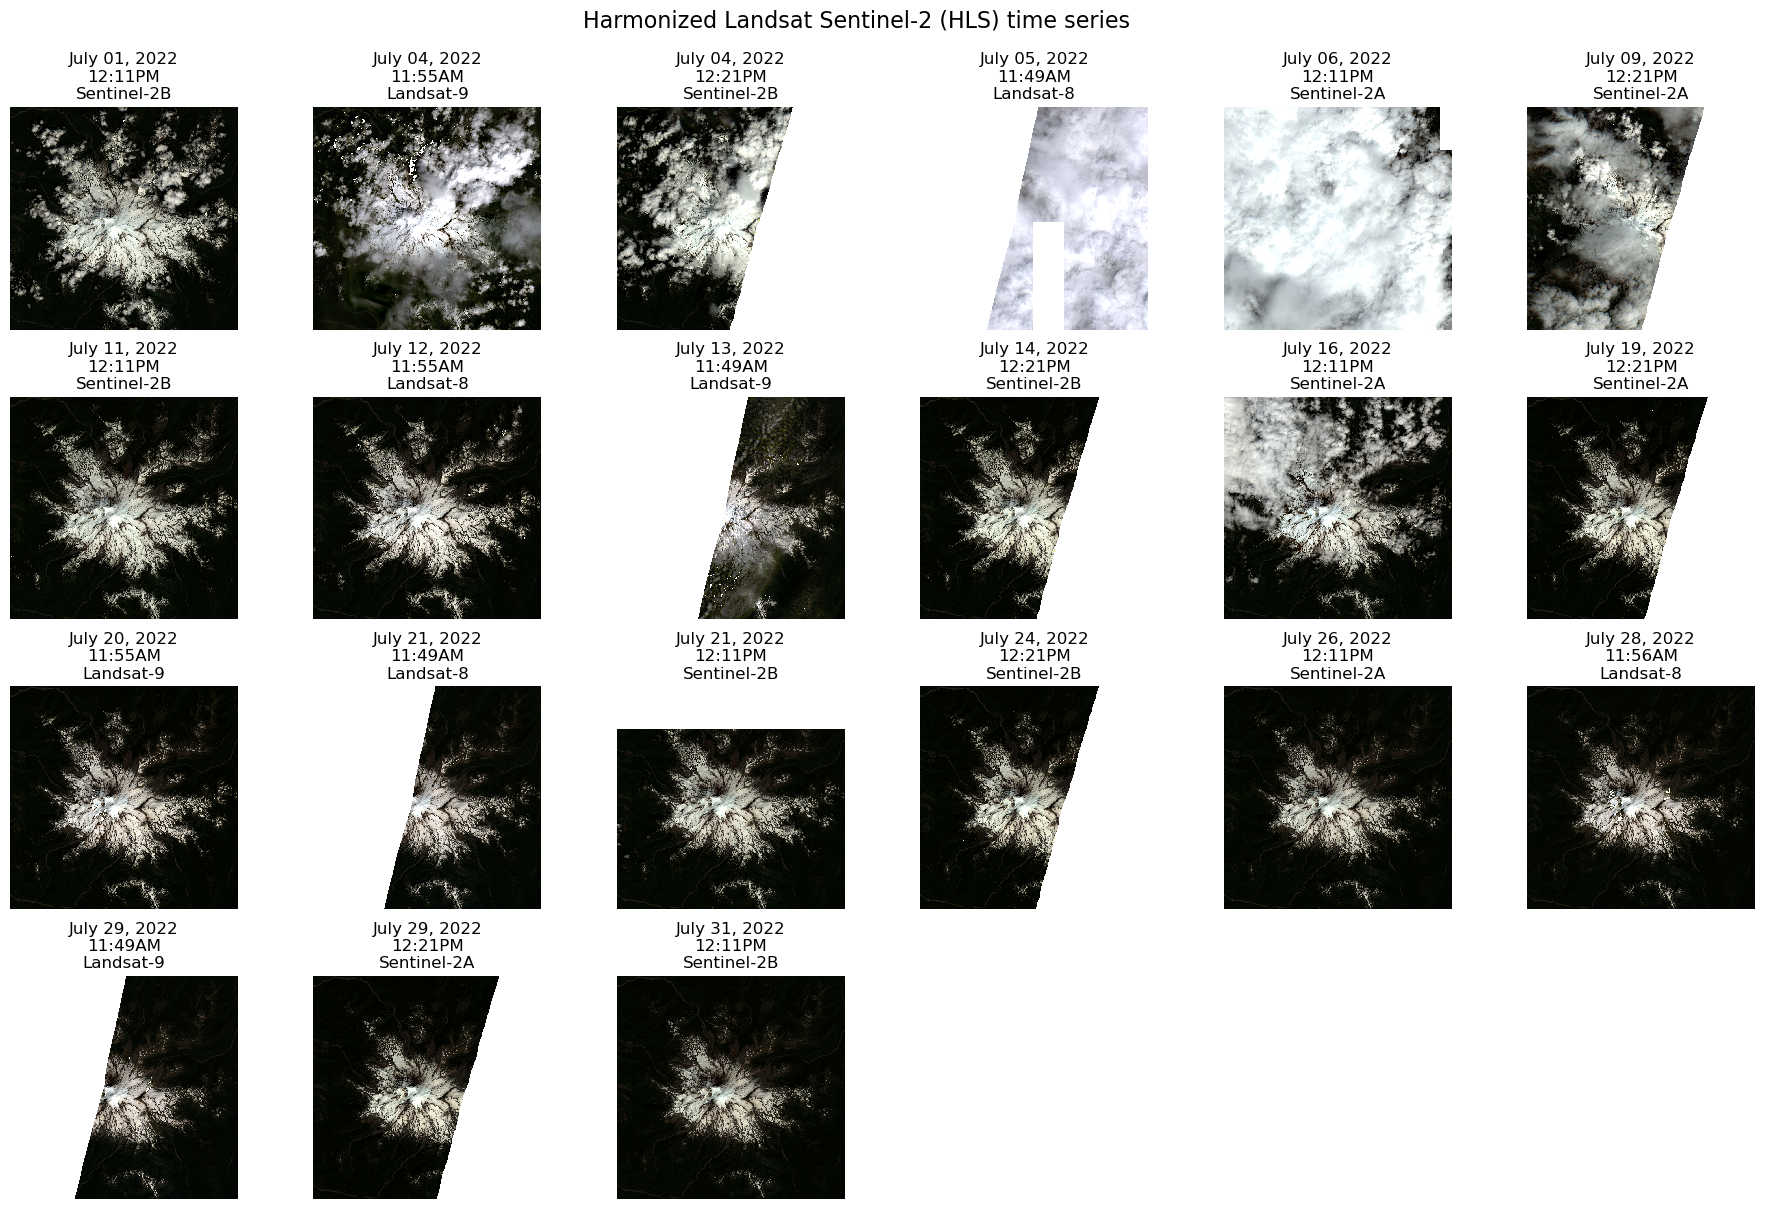

In [26]:
f = hls.rgb.plot.imshow(col='time',col_wrap=6,robust=True)

for ax, time, platform in zip(f.axes.flat, hls.rgb.time.values, hls.rgb.platform.values):
    local_time = pd.to_datetime(time).tz_localize('UTC').tz_convert('America/Los_Angeles')
    ax.set_title(f'{local_time.strftime('%B %d, %Y')}\n{local_time.strftime('%I:%M%p')}\n{platform}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.subplots_adjust(hspace=0.3)
f.fig.suptitle('Harmonized Landsat Sentinel-2 (HLS) time series',fontsize=16,y=1.04)

## MODIS MOD10A1F cloud-gap-filled NDSI

In [27]:
modis_cgf_ndsi = easysnowdata.remote_sensing.get_modis_cgf_NDSI(bbox_gdf, start_date='2022-07-01', end_date='2022-07-31')

Granules found: 31
 Getting 31 granules, approx download size: 0.03 GB


QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

File MOD10A1F.A2022182.h09v04.061.2022184060608.hdf already downloaded
File MOD10A1F.A2022183.h09v04.061.2022185043746.hdf already downloaded
File MOD10A1F.A2022184.h09v04.061.2022186055009.hdf already downloaded
File MOD10A1F.A2022185.h09v04.061.2022187234249.hdf already downloaded
File MOD10A1F.A2022186.h09v04.061.2022188071311.hdf already downloaded
File MOD10A1F.A2022187.h09v04.061.2022189044231.hdf already downloaded
File MOD10A1F.A2022188.h09v04.061.2022190054810.hdf already downloaded
File MOD10A1F.A2022189.h09v04.061.2022191062150.hdf already downloaded
File MOD10A1F.A2022190.h09v04.061.2022192033749.hdf already downloaded
File MOD10A1F.A2022191.h09v04.061.2022193061917.hdf already downloaded
File MOD10A1F.A2022192.h09v04.061.2022194154602.hdf already downloaded
File MOD10A1F.A2022193.h09v04.061.2022195213955.hdf already downloaded
File MOD10A1F.A2022194.h09v04.061.2022196065818.hdf already downloaded
File MOD10A1F.A2022195.h09v04.061.2022197050019.hdf already downloaded
File M

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

In [28]:
modis_cgf_ndsi

<xarray.DataArray 'CGF_NDSI_Snow_Cover' (time: 31, y: 66, x: 167)> Size: 342kB
dask.array<concatenate, shape=(31, 66, 167), dtype=uint8, chunksize=(1, 66, 167), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1kB -9.294e+06 -9.294e+06 ... -9.218e+06 -9.217e+06
  * y            (y) float64 528B 5.226e+06 5.225e+06 ... 5.196e+06 5.196e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 248B 2022-07-01 2022-07-02 ... 2022-07-31
Attributes:
    Key:           0-100=NDSI snow, 200=missing data, 201=no decision, 211=ni...
    long_name:     cloud-gap-filled NDSI snow cover
    valid_range:   0, 100
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

Text(0.5, 1.02, 'MODIS MOD10A1F cloud-gap-filled NDSI')

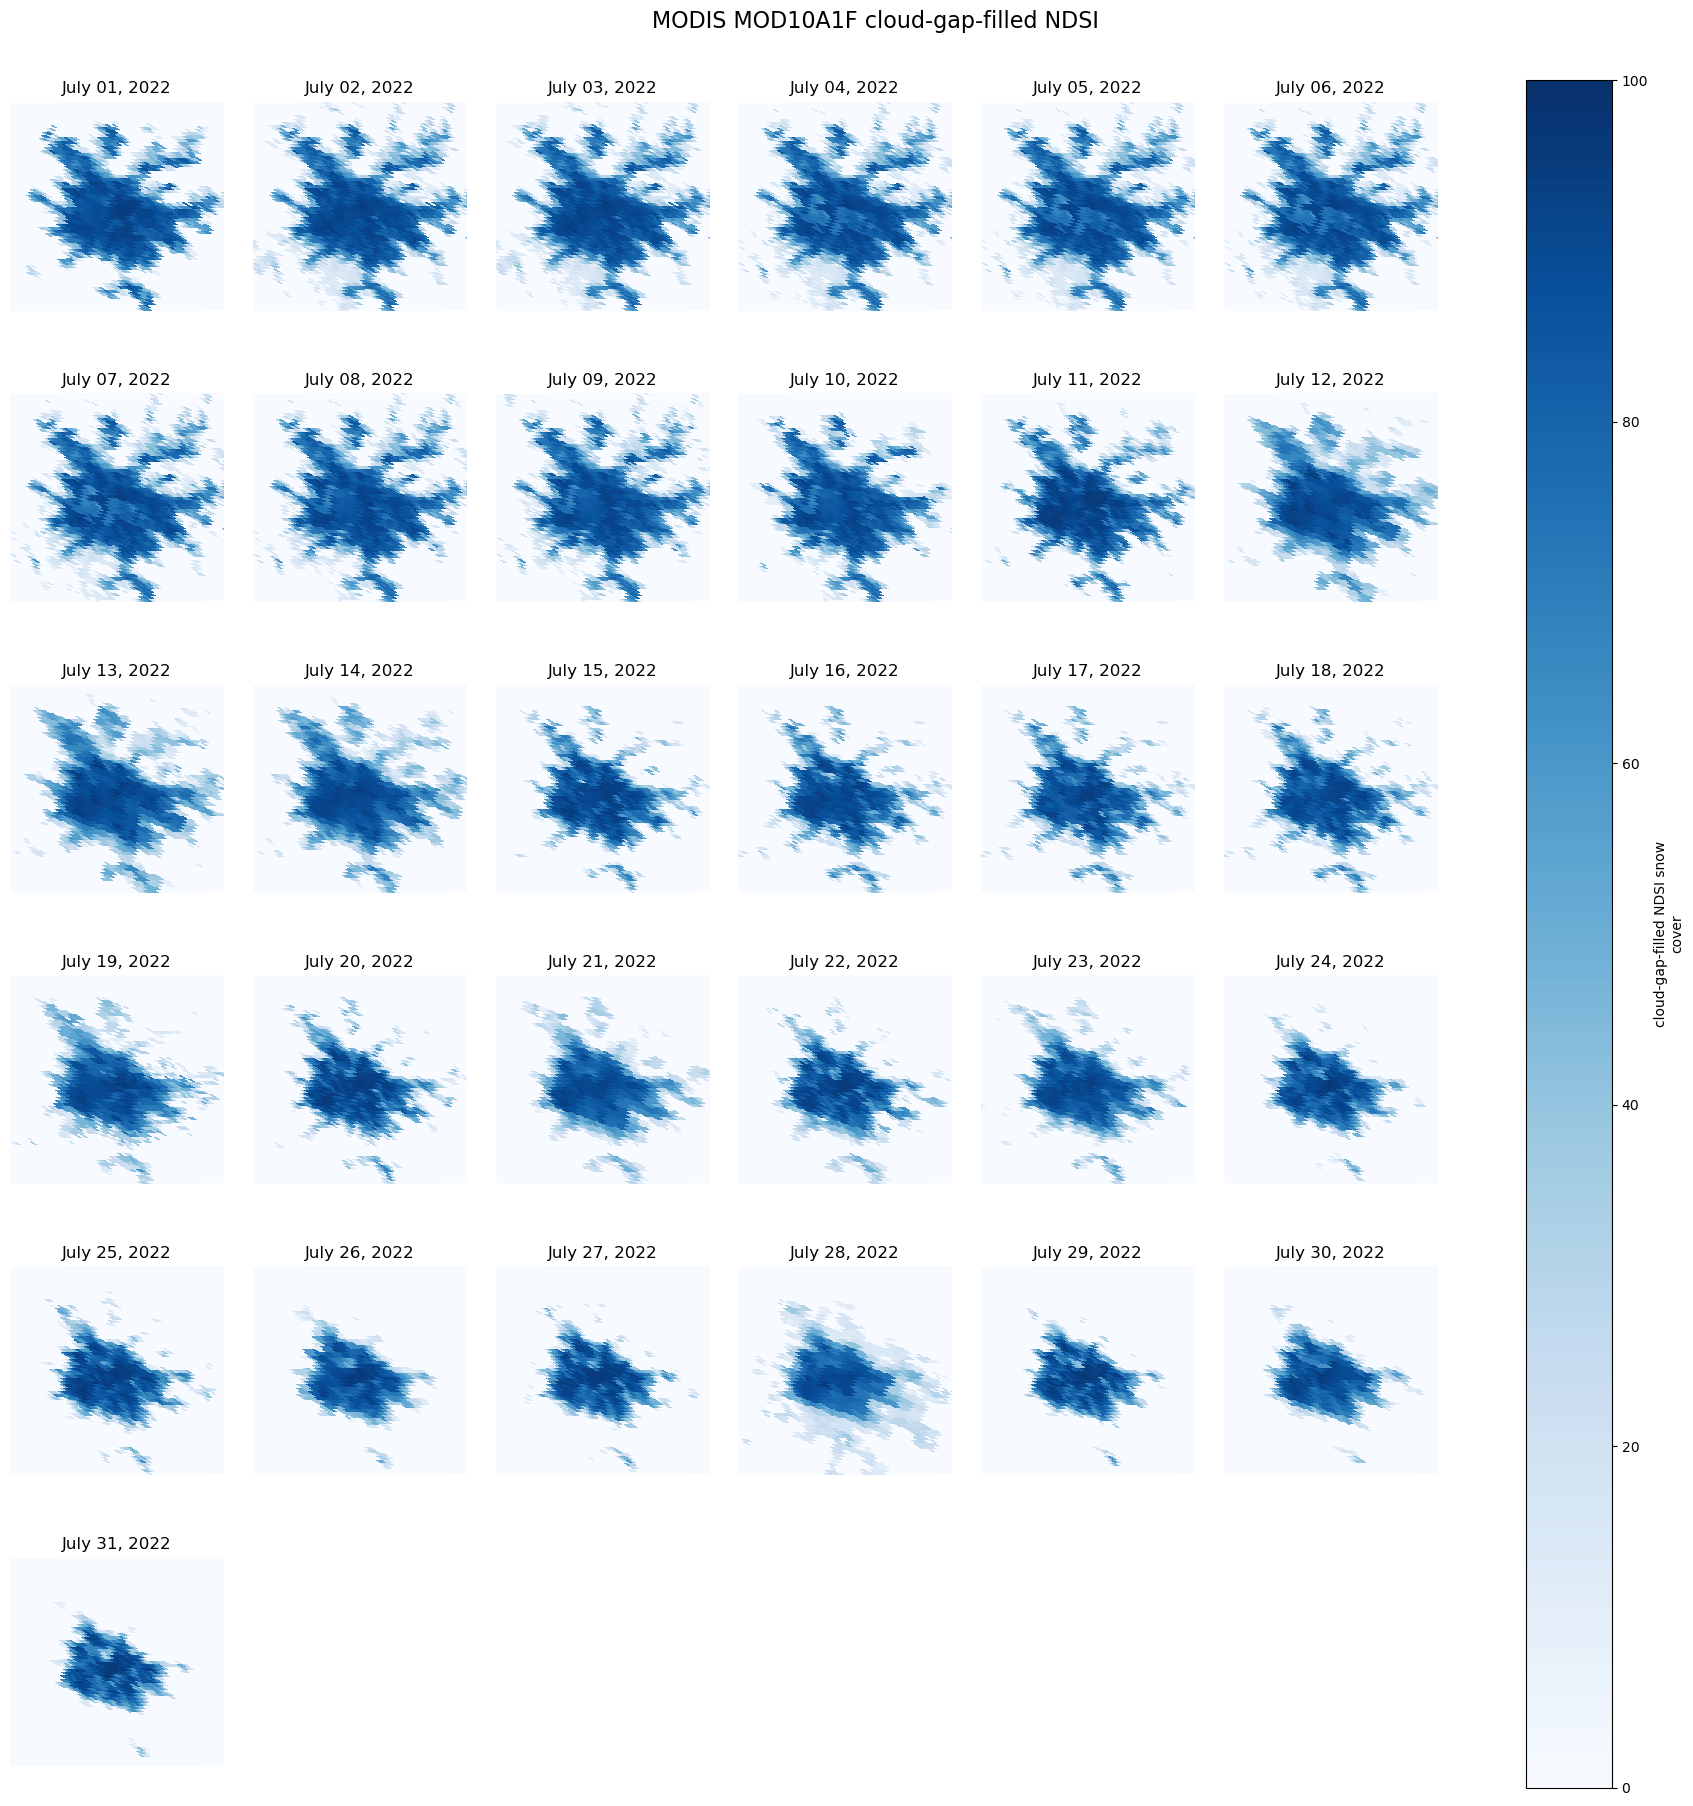

In [38]:
f= modis_cgf_ndsi.rio.reproject_match(hls.data, resampling=rio.enums.Resampling.nearest).where(lambda x: x <= 100).plot.imshow(
    col="time", col_wrap=6, vmin=0, vmax=100, cmap='Blues'
)

for ax, time, in zip(f.axs.flat, modis_cgf_ndsi.time.values):
    ax.set_title(f'{pd.to_datetime(time).strftime('%B %d, %Y')}')
    ax.axis('off')
    ax.set_aspect('equal')

f.fig.suptitle('MODIS MOD10A1F cloud-gap-filled NDSI',fontsize=16,y=1.02)

## MODIS MOD10A1

## PALSAR-2

In [ ]:
list(bbox_gdf.total_bounds)

In [ ]:
!pip install --upgrade xee

In [ ]:
import xee

In [ ]:
!earthengine authenticate --quiet

In [ ]:
import ee

ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com")

In [ ]:
bbox_ee = ee.Geometry.Rectangle(153.0, -43.0, 154.0, -42.0)
bbox_ee = ee.Geometry.Rectangle(*list(bbox_gdf.total_bounds))

In [ ]:
bbox_ee = ee.Geometry.BBox(*list(bbox_gdf.total_bounds))

In [ ]:
bbox_ee.Polygon()

In [ ]:
ic.first().select(0).projection()

In [ ]:
ic = ee.ImageCollection("JAXA/ALOS/PALSAR-2/Level2_2/ScanSAR").filterDate(
    "2022-07-01", "2022-07-31"
)
ds = xr.open_dataset(
    ic,
    geometry=bbox_ee,
    projection=ic.first().select(0).projection(),
    crs="EPSG:4326",
    engine="ee",
    scale=0.01,
)

In [ ]:
ds

In [ ]:
ds["HH"].isel(time=1).plot()

In [ ]:
def dn_to_db(dn):
    db = 10 * np.log10(dn**2) - 83
    return db

In [ ]:
ds["HH"].map_blocks(dn_to_db)

In [ ]:
ds["HH"].isel(time=0)

In [ ]:
ds.time.values[0:10]

In [ ]:
# auth: planetary computer, google earth engine, earthdata, etc. and save?